# CPSC 330 - Applied Machine Learning 

## Homework 2: Decision trees and machine learning fundamentals 
### Associated lectures: [Lectures 2 and 3](https://github.com/UBC-CS/cpsc330-2021W2/tree/main/lectures) 

**Due date: Monday Jan 24, 2022 at 11:59pm**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier

## Instructions
rubric={points:3}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). In particular, **see the note about not pushing downloaded data to your repo**.

You are allowed to work and submit in pairs in this homework assignment. 

## Introducing the data set
 
For this  assignment you'll be looking at Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/) dataset.
The dataset contains a number of features of songs from 2017 and a binary variable `target` that represents whether the user liked the song (encoded as 1) or not (encoded as 0). See the documentation of all the features [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). 

This dataset is publicly available on Kaggle, and you will have to download it yourself. Follow the steps below to get the data CSV. 

1. If you do not have an account with [Kaggle](https://www.kaggle.com/), you will first need to create one (it's free).
2. Login to your account and [download](https://www.kaggle.com/geomack/spotifyclassification/download) the dataset.
3. Unzip the data file if needed, then rename it to `spotify.csv`, and move it to the same directory as this notebook.

## Exercise 1: Exploratory data analysis

#### 1(a) 
rubric={points:2}

Read in the data CSV and store it as a pandas dataframe named `spotify_df`. The first column of the .csv file should be set as the index. **Note:** you may need to change the name of the file if it does not match the download.

In [2]:
spotify_df = pd.read_csv("spotify.csv", index_col=0)

Excluding the target, how many columns (potential features) does the dataset include?

15

#### 1(b)
rubric={points:2}

Run the following line of code to split the data. How many training and test examples do we have?

> Note: we are setting the `random_state` so that everyone has the same split on their assignments. This will make it easier for the TAs to grade.

In [3]:
df_train, df_test = train_test_split(spotify_df, test_size=0.2, random_state=321)
print("Total Examples: ", len(spotify_df.index))
print("Train examples: ", len(df_train.index))
print("Test examples: ", len(df_test.index))

Total Examples:  2017
Train examples:  1613
Test examples:  404


There are 1613 training examples and 404 test examples.

#### 1(c)
rubric={points:3}

- Print out the output of `describe()` **on the training split**. This will compute some summary statistics of the numeric columns.
- Which feature has the largest range? 

> Hint: You can subtract the min value from the max value of the column to get the range.

Note that `describe` returns another DataFrame.

In [4]:
df_train_describe = df_train.describe()

maxRange = -100000000000
maxCol = ''

for col in df_train_describe.columns:
    if col == "target":
        continue
    colRange = df_train_describe.loc["max", col] - df_train_describe.loc["min", col]
    if (colRange > maxRange):
        maxCol = col
        maxRange = colRange
    
print("Column with maximum range is: ", maxCol)

Column with maximum range is:  duration_ms


duration_ms has the largest range.

#### 1(d) 
rubric={points:5}

Let's focus on the following features:

- danceability
- tempo
- energy
- valence

For each of these features (in order), produce a histogram that shows the distribution of the feature values in the training set, **separated for positive and negative examples**. 
By "positive examples" we mean target = 1 (user liked the song, positive sentiment) and by "negative examples" we mean target = 0 (used disliked the song, negative sentiment). As an example, here is what the histogram would look like for a different feature, loudness:



<img src='loudness.png' width="400">

(You don't have to match all the details exactly, such as colour, but your histograms should look something like this, with a reasonable number of bins to see the shape of the distribution.) As shown above, there are two different histograms, one for target = 0 and one for target = 1, and they are overlaid on top of each other. The histogram above shows that extremely quiet songs tend to be disliked (more blue bars than orange on the left) and very loud songs also tend to be disliked (more blue than orange on the far right).

To adhere to the [DRY (Don't Repeat Yourself)](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) principle, make sure you use a `for` loop for your plotting, rather than repeating the plotting code 4 times. For this to work, I used `plt.show()` at the end of the loop, which draws the figure and resets the canvas for your next plot.

Here is some code that separates out the dataset into positive and negative examples, to help you get started:

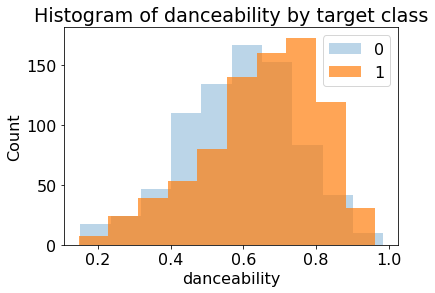

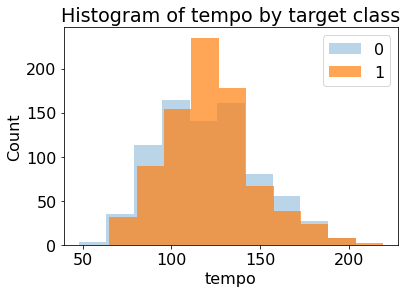

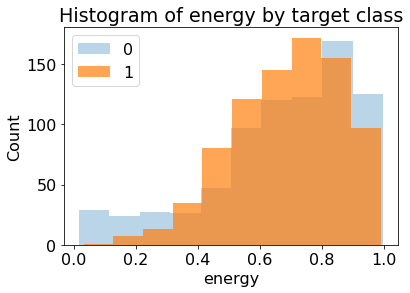

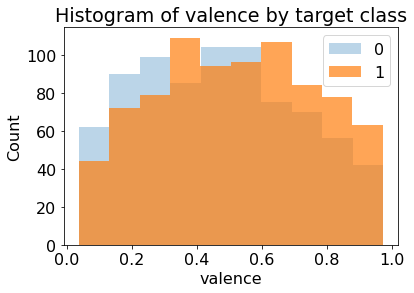

In [5]:
negative_examples = df_train.query("target == 0")
positive_examples = df_train.query("target == 1")

cols = ["danceability", "tempo", "energy", "valence"]

for col in cols:
    negative_col = negative_examples.loc[:, col]
    positive_col = positive_examples.loc[:, col]
    
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title("Histogram of " + col + " by target class")
    
    # added opacity to make graph look similar to the example histogram given above
    plt.hist(negative_col, label='0', alpha=0.3)
    plt.hist(positive_col, label='1', alpha=0.7)
    
    plt.legend();
    plt.show()

#### 1(e)
rubric={points:4}

Let's say you had to make a decision stump (decision tree with depth 1), _by hand_, to predict the target class. Just from looking at the plots above, describe a reasonable split (feature name and threshold) and what class you would predict in the two cases. For example, in the loudness histogram provided earlier on, it seems that very large values of loudness are generally disliked (more blue on the right side of the histogram), so you might answer something like this: "A reasonable split would be to predict 0 if loudness > -5 (and predict 1 otherwise)."

danceability graph: "A reasonable split would be to predict 0 if danceability < 0.65 (and predict 1 otherwise)".
tempo graph: "A reasonable split would be to predict 0 if tempo < 110 (and predict 1 otherwise)".
energy graph: "A reasonable split would be to predict 0 if energy < 0.3 (and predict 1 otherwise)".
valence graph: "A reasonable split would be to predict 0 if valence < 0.6 (and predict 1 otherwise)".

#### 1(f)
rubric={points:2}

Let's say that, for a particular feature, the histograms of that feature are identical for the two target classes. Does that mean the feature is not useful for predicting the target class?


Yes, the feature by itself is not useful in predicting the target class because for the same feature value, we have both target classes (so we can not differentiate between the two classes).

#### 1(g) 
rubric={points:2}

Note that the dataset includes two free text features labeled `song_title` and `artist`:

In [6]:
df_train[["song_title", "artist"]].head()

,song_title,artist
260,WTF (Where They From) [feat. Pharrell Williams],Missy Elliott
1286,"10,000 Reasons (Bless the Lord) [Radio Version]",Matt Redman
1344,American Dream,Chelsea Grin
1197,Feel This Moment,Pitbull
119,Trap Queen,Fetty Wap


- Do you think these features could be useful in predicting whether the user liked the song or not? 
- Would there be any difficulty in using them in your model?   

Artist could be a useful feature if we notice a particular artist has more targets = 1 compared to 0 => we can predict unseen music made by the artist who is already liked is more likely to also have more liked songs.

I don't think song_title is useful in prediction because what users like depends on the sound (what the song sounds like), not the title of the song.

There could be many difficulties involved such as whether people like every new song of an artist just becuase they like their previous music. While it is a good indicator, it isn't perfect.

Incorporating song_title is the most problematic, because it has very little correlation to whether someone likes the song, unless the title is too extreme (inappropriately explicit or childish). Therefore, it is not a good indicator to generalize and could make our model overfit to specifc training data quirks.

<br><br>

## Exercise 2: Using sklearn to build a decision tree classifier

#### 2(a) 
rubric={points:2}

- Create `X_train` and `y_train` and `X_test` and `y_test` from `df_train` and `df_test` above. Skip the `song_title` and `artist` features for now. 
- Fit a `DecisionTreeClassifier` on the train set.

In [7]:
X_train = df_train.drop(columns=["target", "song_title", "artist"])
y_train = df_train["target"]

X_test = df_test.drop(columns=["target", "song_title", "artist"])
y_test = df_test["target"]

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

#### 2(b)
rubric={points:2}

Use the `predict` method to predict the class of the tenth example in your `X_train`. Is the prediction correct? That is, does it match with the corresponding class in `y_train`?  

> Hint: you can grab the tenth example with `X_train.iloc[[9]]`.

In [8]:
print(model.predict(X_train.iloc[[9]]))
print(y_train[9])

[1]
1


Yes, the prediction of target = 1 is correct (it matches y_train).

#### 2(c) 
rubric={points:2}

Use the `cross_val_score` function on your training set to compute the 10-fold cross-validation accuracy of your tree. 

In [9]:
# gives us validation scores for all 10 folds
cv_scores = cross_val_score(model, X_train, y_train, cv=10)
print(cv_scores)

[0.67901235 0.61111111 0.64814815 0.72049689 0.75776398 0.58385093
 0.70186335 0.72670807 0.63975155 0.70186335]


#### 2(d)
rubric={points:2}

The above is useful, but we would like to see the training accuracy as well. 

- Compute the 10-fold cross-validation again but this time using the `cross_validate` function with `return_train_score=True`. 
- Print out both the cross-validation score and the training score.
- Is your cross-validation score exactly the same as what you got in the previous part? Very briefly discuss.

In [10]:
# gives us validation scores for all 10 folds
cross_valid_scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
df_cross_valid_scores = pd.DataFrame(cross_valid_scores)
print(df_cross_valid_scores[["test_score"]])
print(df_cross_valid_scores[["train_score"]])

   test_score
0    0.685185
1    0.611111
2    0.666667
3    0.726708
4    0.714286
5    0.614907
6    0.745342
7    0.714286
8    0.677019
9    0.695652
   train_score
0     0.999311
1     0.998622
2     0.999311
3     0.998623
4     0.998623
5     0.998623
6     0.998623
7     0.999311
8     0.999311
9     0.998623


No, the cross-validation scores are not exactly the same as the previous part. This is because the folds are calculated randomly every time the cross_val_score and cross_validate functions are called.

#### 2(e)
rubric={points:1}

Do you see a significant difference between the training score and the cross-validation score? Briefly discuss.

Yes, the training scores are much higher than the cross_validation scores. This is because no depth is specified to the model, so it is boundless. This will result in an overfit model that is extremely specialized in the training data but unable to generalize well with validation data.

#### 2(f)
rubric={points:1}

Inspect the 10 sub-scores from the 10 folds of cross-validation. How does this inform the trustworthiness of your cross validation score?

In [11]:
print(df_cross_valid_scores[["test_score"]])

   test_score
0    0.685185
1    0.611111
2    0.666667
3    0.726708
4    0.714286
5    0.614907
6    0.745342
7    0.714286
8    0.677019
9    0.695652


The scores lie between 0.59 and 0.75. These scores are quite low especially compared to the training score, and thus aren't trustiworthy enough to predict test and unseen data.

## Exercise 3: Hyperparameters 
rubric={points:10}

In this exercise, you'll experiment with the `max_depth` hyperparameter of the decision tree classifier. See the [`DecisionTreeClassifier` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more details.

- Explore the `max_depth` hyperparameter. Run 10-fold cross-validation for trees with different values of `max_depth` (at least 10 different values in the range 1 to 25).
- For each `max_depth`, get both the train accuracy and the cross-validation accuracy.
- Make a plot with `max_depth` on the *x*-axis and the train and cross-validation scores on the *y*-axis. That is, your plot should have two curves, one for train and one for cross-validation. Include a legend to specify which is which.
- Discuss how changing the `max_depth` hyperparameter affects the training and cross-validation accuracy. From these results, what depth would you pick as the optimal depth? 
- Do you think that the depth you chose would generalize to other "spotify" datasets (i.e., data on other spotify users)?

> Note: generally speaking (for all assignments) you are welcome to copy/paste code directly from the lecture notes, though I ask that you add a small citation (e.g. "Adapted from lecture 2") if you do so.

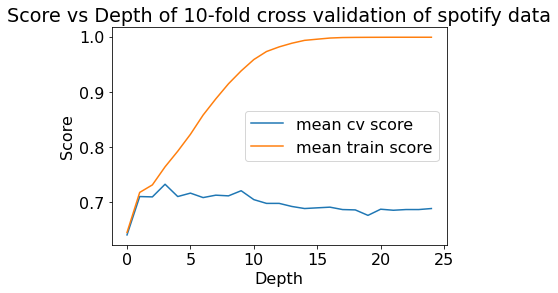

In [12]:
depths = list(range(1,26))
mean_cv_score_arr = []
mean_train_score_arr = []


# print(depths)

for depth in depths:
    hyper_model = DecisionTreeClassifier(max_depth=depth)
    hyper_cv_scores = cross_validate(hyper_model, X_train, y_train, cv=10, return_train_score=True)
    
    df_hyper_scores = pd.DataFrame(hyper_cv_scores)
    df_hyper_scores_descript = df_hyper_scores.describe()
    
    mean_cv_score_arr.append(df_hyper_scores_descript.loc["mean", "test_score"])
    mean_train_score_arr.append(df_hyper_scores_descript.loc["mean", "train_score"])

    
# graph the data
plt.xlabel("Depth")
plt.ylabel("Score")
plt.title("Score vs Depth of 10-fold cross validation of spotify data")
    
plt.plot(mean_cv_score_arr, label='mean cv score')
plt.plot(mean_train_score_arr, label='mean train score')
    
plt.legend();
plt.show()

Q1) Discuss how changing the max_depth hyperparameter affects the training and cross-validation accuracy. From these results, what depth would you pick as the optimal depth?
ANS1) Increasing the max_depth hyperparameter increases the training accuracy drastically as it plateaus near 0.98-0.99 at about depth 15. Also, the increasing the max_depth intially from 0-3 causes the validation accuracy to peak, after that point, the validation score decreases gradually with higher and higher depth.

I would pick depth 3 as the optimal depth because this is the cross-validation peak accuracy, making it the best candidate/model for test/unseen data.

Q2) Do you think that the depth you chose would generalize to other "spotify" datasets (i.e., data on other spotify users)?
ANS2)Yes, I believe a depth of 3 is not very complex and specialized to the training data, thereby allowing it generalize other "spotify" datasets.

## Exercise 4: Test set
rubric={points:4}

Remember the test set you created way back at the beginning of this assignment? Let's use it now to see if our cross-validation score from the previous exercise is trustworthy. 

- Select your favorite `max_depth` from the previous part.
- Train a decision tree classifier using that `max_depth` on the _entire training set_.
- Compute and display the test score. 
- How does it compare to the cross-validation score from the previous exercise? Briefly discuss. 

In [13]:
optimal_depth = 3
optimal_model = DecisionTreeClassifier(max_depth=optimal_depth)
optimal_model.fit(X_train, y_train)


print("Test Score: " + str(optimal_model.score(X_test, y_test)))

Test Score: 0.6683168316831684


The test score is 0.6683168316831684. It is about 6 percent lower than the cross_validation score of approximately 0.72.  This is to be expected, as Error for test scores is usually lower than cross_validation scores. However, the gap is not very large, thus making this the optimal model based on the given TreeClassifier and training data we were given.

## Exercise 5: Conceptual questions
rubric={points:3}

Consider the dataset below, which has $6$ examples and $2$ features:

$$ X = \begin{bmatrix}5 & 2\\4 & 3\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}-1\\-1\\-1\\-1\\+1\\+1\end{bmatrix}.$$

1. Say we fit a decision stump (depth 1 decision tree) and the first split is on the first feature (left column) being less than 5.5. What would we predict in the "true" and "false" cases here?
2. What training accuracy would the above stump get on this data set?
3. Can we obtain 100% accuracy with a single decision stump in this particular example?

1) We would predict examples 0,1,2 to be True. Examples 3,4,5 would be False.
2) Assuming True is +1 and False is -1. It got the following predictions correct: example 3. Therefore accuracy is 1/6 = 0.17
3) Yes, by setting the condition and threshold to be: "if the first feature is equal to 9, then it is True. Otherwise, it is False".

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 